In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from medmnist import PathMNIST
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch

In [2]:
# Set dataset info
data_flag = 'pathmnist'

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = PathMNIST(split='train', transform=data_transform, download=True, root = "../data/raw")
val_dataset = PathMNIST(split='val', transform=data_transform, download=True, root = "../data/raw")
test_dataset = PathMNIST(split='test', transform=data_transform, download=True, root = "../data/raw")

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Using downloaded and verified file: ../data/raw/pathmnist.npz
Using downloaded and verified file: ../data/raw/pathmnist.npz
Using downloaded and verified file: ../data/raw/pathmnist.npz


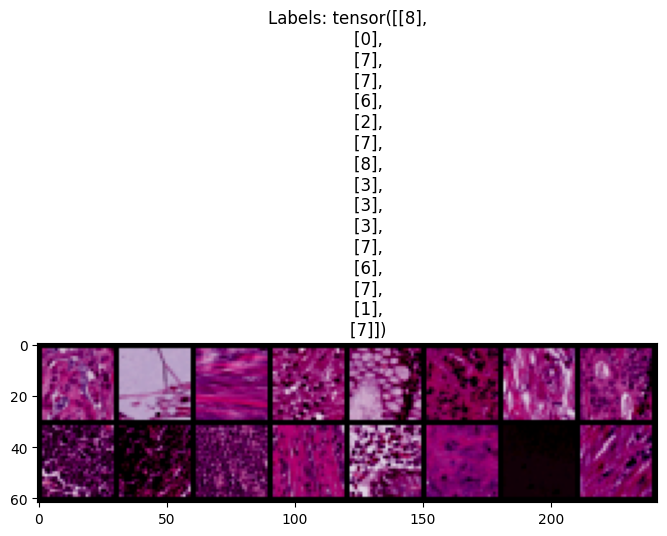

In [3]:
# Visualize some images
def show_images(images, labels):
    plt.figure(figsize=(8, 8))
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(f'Labels: {labels}')
    plt.show()

# Get one batch of training images
images, labels = next(iter(train_loader))
show_images(images[:16], labels[:16])

In [4]:
# Updated data transformations with augmentations
data_transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply to the train dataset
train_dataset.transform = data_transform_augmented

In [4]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [5]:
def train_model(model, criterion, optimizer, num_epochs=1):
    total_steps = len(train_loader)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze().long())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Log the loss
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                avg_loss = running_loss / 100
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {avg_loss:.4f}')
                mlflow.log_metric("batch_loss", avg_loss, step=epoch * total_steps + i)
                running_loss = 0.0
        
        # Log system metrics and average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        mlflow.log_metric("train_loss", avg_loss, step=epoch)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot and log confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Save the confusion matrix plot
    confusion_matrix_path = "confusion_matrix.png"
    plt.savefig(confusion_matrix_path)
    plt.close()

    # Log the confusion matrix plot as an artifact in MLFlow
    mlflow.log_artifact(confusion_matrix_path)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Log evaluation metrics to MLFlow
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1", f1)

    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Plot and log confusion matrix as an artifact
    plot_confusion_matrix(conf_matrix)

    return accuracy

In [12]:
experiment_name = "PathMNIST"

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/617107591268245543', creation_time=1729541237301, experiment_id='617107591268245543', last_update_time=1729541237301, lifecycle_stage='active', name='PathMNIST', tags={}>

In [13]:
from datetime import datetime

with mlflow.start_run(
    run_name="PathMNIST_example5",
    description = "Simple CNN model for PathMNIST classification.",
    log_system_metrics=True
    ):

    epochs = 1
    # Log parameters
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("learning_rate", 0.001)

    # Add tags for better traceability
    mlflow.set_tag("project", "PathMNIST Classification")
    mlflow.set_tag("developer", "Ivan Reyes")
    mlflow.set_tag("timestamp", str(datetime.now()))

    # Add metadata and description
    mlflow.set_tag("model_description", "A simple convolutional neural network with two convolutional layers, followed by two fully connected layers.")
    mlflow.set_tag("model_architecture", "CNN")
    mlflow.set_tag("dataset", "PathMNIST")

    # Initialize the model, criterion, and optimizer
    model = CNNModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, criterion, optimizer, num_epochs=epochs)

    # Evaluate the model
    val_accuracy = evaluate_model(model, val_loader)
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Save the model
    mlflow.pytorch.log_model(model, "PathMNIST_cnn_model")

2024/10/21 14:10:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/10/21 14:10:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch [1/1], Step [100/1407], Loss: 1.1247
Epoch [1/1], Step [200/1407], Loss: 0.8175
Epoch [1/1], Step [300/1407], Loss: 0.7357
Epoch [1/1], Step [400/1407], Loss: 0.6780
Epoch [1/1], Step [500/1407], Loss: 0.6125
Epoch [1/1], Step [600/1407], Loss: 0.6141
Epoch [1/1], Step [700/1407], Loss: 0.5433
Epoch [1/1], Step [800/1407], Loss: 0.5496
Epoch [1/1], Step [900/1407], Loss: 0.5107
Epoch [1/1], Step [1000/1407], Loss: 0.4629
Epoch [1/1], Step [1100/1407], Loss: 0.4707
Epoch [1/1], Step [1200/1407], Loss: 0.4413
Epoch [1/1], Step [1300/1407], Loss: 0.4236
Epoch [1/1], Step [1400/1407], Loss: 0.4171
Epoch [1/1], Loss: 0.0018
Validation Accuracy: 0.84%
Precision: 0.84
Recall: 0.83
F1 Score: 0.83
Validation Accuracy: 0.8370


2024/10/21 14:12:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/21 14:12:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run PathMNIST_example5 at: http://127.0.0.1:5000/#/experiments/617107591268245543/runs/adca5b681fb54667a3b5e82114034130.
2024/10/21 14:12:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/617107591268245543.
2024/10/21 14:12:39 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/21 14:12:39 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
